In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import tensorwatch as tw
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from arff2pandas import a2p

from pyts.image import MarkovTransitionField
from pyts.image import RecurrencePlot
from pyts.datasets import load_gunpoint

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='darkgrid')
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

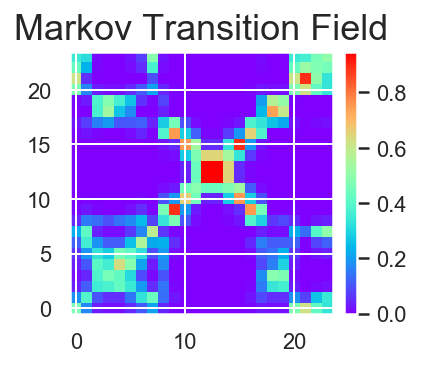

In [2]:
# MTF Sample
X, _, _, _ = load_gunpoint(return_X_y=True)

# MTF transformation
mtf = MarkovTransitionField(image_size=24)
X_mtf = mtf.fit_transform(X)

# Show the image for the first time series
plt.figure(figsize=(3, 3))
plt.imshow(X_mtf[0], cmap='rainbow', origin='lower')
plt.title('Markov Transition Field', fontsize=18)
plt.colorbar(fraction=0.0457, pad=0.04)
plt.tight_layout()
plt.show()

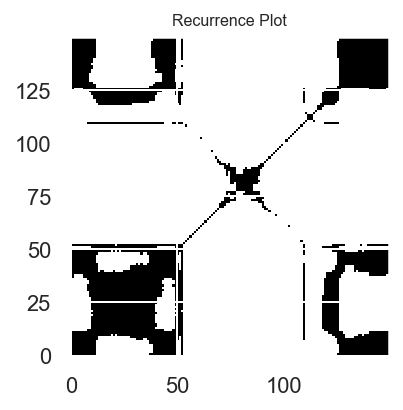

In [4]:
X, _, _, _ = load_gunpoint(return_X_y=True)

# Recurrence plot transformation
rp = RecurrencePlot(threshold='point', percentage=20)
X_rp = rp.fit_transform(X)

# Show the results for the first time series
plt.figure(figsize=(3, 3))
plt.imshow(X_rp[0], cmap='binary', origin='lower')
plt.title('Recurrence Plot', fontsize=8)
plt.tight_layout()
plt.show()

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open('./ECG5000/ECG5000_TRAIN.arff') as f:
  train = a2p.load(f)

with open('./ECG5000/ECG5000_TEST.arff') as f:
  test = a2p.load(f)

df = train.append(test)
df = df.sample(frac=1.0)
print(df.shape)
CLASS_NORMAL = 1
class_names = ['Normal','R on T','PVC','SP','UB']

new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns
df.head()

(5000, 141)


,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,att11@NUMERIC,att12@NUMERIC,att13@NUMERIC,att14@NUMERIC,att15@NUMERIC,att16@NUMERIC,att17@NUMERIC,att18@NUMERIC,att19@NUMERIC,att20@NUMERIC,att21@NUMERIC,att22@NUMERIC,att23@NUMERIC,att24@NUMERIC,att25@NUMERIC,att26@NUMERIC,att27@NUMERIC,att28@NUMERIC,att29@NUMERIC,att30@NUMERIC,att31@NUMERIC,att32@NUMERIC,att33@NUMERIC,att34@NUMERIC,att35@NUMERIC,att36@NUMERIC,att37@NUMERIC,att38@NUMERIC,att39@NUMERIC,att40@NUMERIC,att41@NUMERIC,att42@NUMERIC,att43@NUMERIC,att44@NUMERIC,att45@NUMERIC,att46@NUMERIC,att47@NUMERIC,att48@NUMERIC,att49@NUMERIC,att50@NUMERIC,att51@NUMERIC,att52@NUMERIC,att53@NUMERIC,att54@NUMERIC,att55@NUMERIC,att56@NUMERIC,att57@NUMERIC,att58@NUMERIC,att59@NUMERIC,att60@NUMERIC,att61@NUMERIC,att62@NUMERIC,att63@NUMERIC,att64@NUMERIC,att65@NUMERIC,att66@NUMERIC,att67@NUMERIC,att68@NUMERIC,att69@NUMERIC,att70@NUMERIC,att71@NUMERIC,att72@NUMERIC,att73@NUMERIC,att74@NUMERIC,att75@NUMERIC,att76@NUMERIC,att77@NUMERIC,att78@NUMERIC,att79@NUMERIC,att80@NUMERIC,att81@NUMERIC,att82@NUMERIC,att83@NUMERIC,att84@NUMERIC,att85@NUMERIC,att86@NUMERIC,att87@NUMERIC,att88@NUMERIC,att89@NUMERIC,att90@NUMERIC,att91@NUMERIC,att92@NUMERIC,att93@NUMERIC,att94@NUMERIC,att95@NUMERIC,att96@NUMERIC,att97@NUMERIC,att98@NUMERIC,att99@NUMERIC,att100@NUMERIC,att101@NUMERIC,att102@NUMERIC,att103@NUMERIC,att104@NUMERIC,att105@NUMERIC,att106@NUMERIC,att107@NUMERIC,att108@NUMERIC,att109@NUMERIC,att110@NUMERIC,att111@NUMERIC,att112@NUMERIC,att113@NUMERIC,att114@NUMERIC,att115@NUMERIC,att116@NUMERIC,att117@NUMERIC,att118@NUMERIC,att119@NUMERIC,att120@NUMERIC,att121@NUMERIC,att122@NUMERIC,att123@NUMERIC,att124@NUMERIC,att125@NUMERIC,att126@NUMERIC,att127@NUMERIC,att128@NUMERIC,att129@NUMERIC,att130@NUMERIC,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,target
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,-0.166753,0.011275,-0.147008,-0.088714,-0.114587,-0.146307,-0.157915,-0.027796,-0.214186,-0.141600,-0.210829,-0.203778,-0.153019,-0.266533,-0.390077,-0.327032,-0.400833,-0.407830,-0.501358,-0.522868,-0.574155,-0.659348,-0.663703,-0.724858,-0.682038,-0.770026,-0.798246,-0.747866,-0.758533,-0.591910,-0.613589,-0.484648,-0.321207,-0.347201,-0.211714,-0.180515,-0.114905,0.040090,-0.009205,0.119011,0.100743,0.102592,0.060509,0.047889,0.127408,0.079887,0.143513,0.136941,0.204646,0.152274,0.229859,0.224330,0.262933,0.339575,0.283558,0.279419,0.355053,0.344668,0.407459,0.436377,0.465461,0.544820,0.437736,0.407568,0.459962,0.418811,0.433495,0.364673,0.395376,0.343256,0.302243,0.311304,0.306973,0.339895,0.286992,0.239494,0.134686,0.145451,0.167923,0.130802,0.249490,0.225841,0.180988,0.220100,0.254596,0.356024,0.479893,0.561210,0.775010,0.946014,1.233402,1.487003,1.675518,1.836158,1.767251,1.735520,1.630994,1.380285,1.062822,0.829051,0.559157,0.189454,-0.083072,-0.387828,-0.484409,-0.490306,-0.518586,-0.419299,-0.440095,-0.357985,-0.486044,-0.486691,-0.376997,-0.444405,-0.295011,-0.381458,-0.357774,-0.308135,-0.068073,0.510416,0.873347,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,1
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,-0.262474,-0.197361,-0.340497,-0.323774,-0.335513,-0.254583,-0.264334,-0.338740,-0.284649,-0.368613,-0.394213,-0.439726,-0.368993,-0.376742,-0.423022,-0.529464,-0.589248,-0.544008,-0.518129,-0.678544,-0.717577,-0.740041,-0.769233,-0.785213,-0.821685,-0.769256,-0.772686,-0.781586,-0.818404,-0.769080,-0.646446,-0.565461,-0.530353,-0.461239,-0.353780,-0.345354,-0.246567,-0.137200,-0.125065,-0.146301,-0.097487,-0.050911,-0.065833,-0.096573,-0.079000,-0.119623,-0.023226,0.006492,-0.043704,-0.014412,0.015729,0.005288,-0.025530,0.005026,0.076812,0.033831,0.108051,0

In [6]:
normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)
anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
print(normal_df.shape, anomaly_df.shape)

(2919, 140)(2081, 140)


In [7]:
normal_X = normal_df.values
anomaly_X = anomaly_df.values

mtf = MarkovTransitionField(image_size=28)
normal_mtf = mtf.fit_transform(normal_X)
anomaly_mtf = mtf.fit_transform(anomaly_X)
print(normal_mtf.shape, anomaly_mtf.shape)

rp = RecurrencePlot(threshold='point', percentage=20)
normal_rp = rp.fit_transform(normal_X)
anomaly_rp = rp.fit_transform(anomaly_X)
print(normal_rp.shape, anomaly_rp.shape)

(2919, 28, 28)(2081, 28, 28)
(2919, 140, 140)(2081, 140, 140)


In [5]:
# Show the image for the first time series
plt.figure(figsize=(12, 8))

for i in range(1,16):
    plt.subplot(3,5,i)
    plt.imshow(normal_mtf[i], cmap='rainbow', origin='lower')

plt.title('Markov Transition Field', fontsize=8)
plt.colorbar(fraction=0.0457, pad=0.04)
plt.tight_layout()
plt.show()

NameError: name 'normal_mtf' is not defined

In [ ]:
# Show the image for the first time series
plt.figure(figsize=(12, 8))

for i in range(1,16):
    plt.subplot(3,5,i)
    plt.imshow(anomaly_mtf[i], cmap='rainbow', origin='lower')

plt.title('Markov Transition Field', fontsize=8)
plt.colorbar(fraction=0.0457, pad=0.04)
plt.tight_layout()
plt.show()

In [10]:
train_normal, val_normal  = train_test_split(normal_mtf, test_size = 0.15, random_state=RANDOM_SEED)
val_normal, test_normal = train_test_split(val_normal, test_size = 0.33, random_state=RANDOM_SEED)
train_anomaly, val_anomaly = train_test_split(anomaly_mtf, test_size = 0.15, random_state=RANDOM_SEED)
val_anomaly, test_anomaly = train_test_split(val_anomaly, test_size = 0.33, random_state=RANDOM_SEED)
# print(train_normal.shape, val_normal.shape)

train_x = torch.cat((torch.from_numpy(train_normal),torch.from_numpy(train_anomaly)), dim = 0)
val_x = torch.cat((torch.from_numpy(val_normal),torch.from_numpy(val_anomaly)), dim = 0)
test_x = torch.cat((torch.from_numpy(test_normal),torch.from_numpy(test_anomaly)), dim = 0)
train_y = torch.from_numpy(np.array([1]*train_normal.shape[0] + [0]*train_anomaly.shape[0]))
val_y = torch.from_numpy(np.array([1]*val_normal.shape[0] + [0]*val_anomaly.shape[0]))
test_y = torch.from_numpy(np.array([1]*test_normal.shape[0] + [0]*test_anomaly.shape[0]))
(train_x.shape, val_x.shape, test_x.shape, train_y.shape, val_y.shape, test_y.shape)

(torch.Size([4249, 28, 28]),
 torch.Size([502, 28, 28]),
 torch.Size([249, 28, 28]),
 torch.Size([4249]),
 torch.Size([502]),
 torch.Size([249]))

In [11]:
# 转换为torch张量
train_x = train_x.reshape(4249, 1, 28, 28)
train_y = train_y.type(torch.LongTensor)
val_x = val_x.reshape(502, 1, 28, 28)
val_y = val_y.type(torch.LongTensor)
test_x = test_x.reshape(249, 1, 28, 28)
test_y = test_y.type(torch.LongTensor)
# 训练集形状
(train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape)

(torch.Size([4249, 1, 28, 28]),
 torch.Size([4249]),
 torch.Size([502, 1, 28, 28]),
 torch.Size([502]),
 torch.Size([249, 1, 28, 28]),
 torch.Size([249]))

In [8]:
train_normal, val_normal  = train_test_split(normal_rp, test_size = 0.15, random_state=RANDOM_SEED)
val_normal, test_normal = train_test_split(val_normal, test_size = 0.33, random_state=RANDOM_SEED)
train_anomaly, val_anomaly = train_test_split(anomaly_rp, test_size = 0.15, random_state=RANDOM_SEED)
val_anomaly, test_anomaly = train_test_split(val_anomaly, test_size = 0.33, random_state=RANDOM_SEED)
# print(train_normal.shape, val_normal.shape)

train_x = torch.cat((torch.from_numpy(train_normal),torch.from_numpy(train_anomaly)), dim = 0)
val_x = torch.cat((torch.from_numpy(val_normal),torch.from_numpy(val_anomaly)), dim = 0)
test_x = torch.cat((torch.from_numpy(test_normal),torch.from_numpy(test_anomaly)), dim = 0)
train_y = torch.from_numpy(np.array([1]*train_normal.shape[0] + [0]*train_anomaly.shape[0]))
val_y = torch.from_numpy(np.array([1]*val_normal.shape[0] + [0]*val_anomaly.shape[0]))
test_y = torch.from_numpy(np.array([1]*test_normal.shape[0] + [0]*test_anomaly.shape[0]))
(train_x.shape, val_x.shape, test_x.shape, train_y.shape, val_y.shape, test_y.shape)

# 转换为torch张量
train_x = train_x.reshape(4249, 1, 140, 140)
train_y = train_y.type(torch.LongTensor)
val_x = val_x.reshape(502, 1, 140, 140)
val_y = val_y.type(torch.LongTensor)
test_x = test_x.reshape(249, 1, 140, 140)
test_y = test_y.type(torch.LongTensor)
# 训练集形状
(train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape)

(torch.Size([4249, 1, 140, 140]),
 torch.Size([4249]),
 torch.Size([502, 1, 140, 140]),
 torch.Size([502]),
 torch.Size([249, 1, 140, 140]),
 torch.Size([249]))

In [9]:
class Net(nn.Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = nn.Sequential(
            # 定义2D卷积层
            nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 定义另一个2D卷积层
            nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(4 * 7 * 7, 2)
        )

    # 前项传播
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [10]:
model = Net()
# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.05)
# 定义loss函数
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=196, out_features=2, bias=True)
  )
)


In [11]:
def train(epoch):
    model.train()
    tr_loss = 0
    # 获取训练集
    x_train, y_train = train_x.type(torch.FloatTensor), train_y
    # 获取验证集
    x_val, y_val = val_x.type(torch.FloatTensor), val_y
    # 转换为GPU格式
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # 清除梯度
    optimizer.zero_grad()
    
    # 预测训练与验证集
    output_train = model(x_train)
    output_val = model(x_val)

    # 计算训练集与验证集损失
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # 更新权重
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # 输出验证集loss
        print('Epoch : ',epoch, '\t', 'loss :', loss_val)

In [12]:
# 定义轮数
# n_epochs = 25
n_epochs = 10
# 空列表存储训练集损失
train_losses = []
# 空列表存储验证集损失
val_losses = []
# 训练模型
for epoch in range(n_epochs):
    train(epoch)

RuntimeError: CUDA out of memory. Tried to allocate 1.24 GiB (GPU 0; 2.00 GiB total capacity; 356.05 MiB already allocated; 1009.93 MiB free; 358.00 MiB reserved in total by PyTorch)

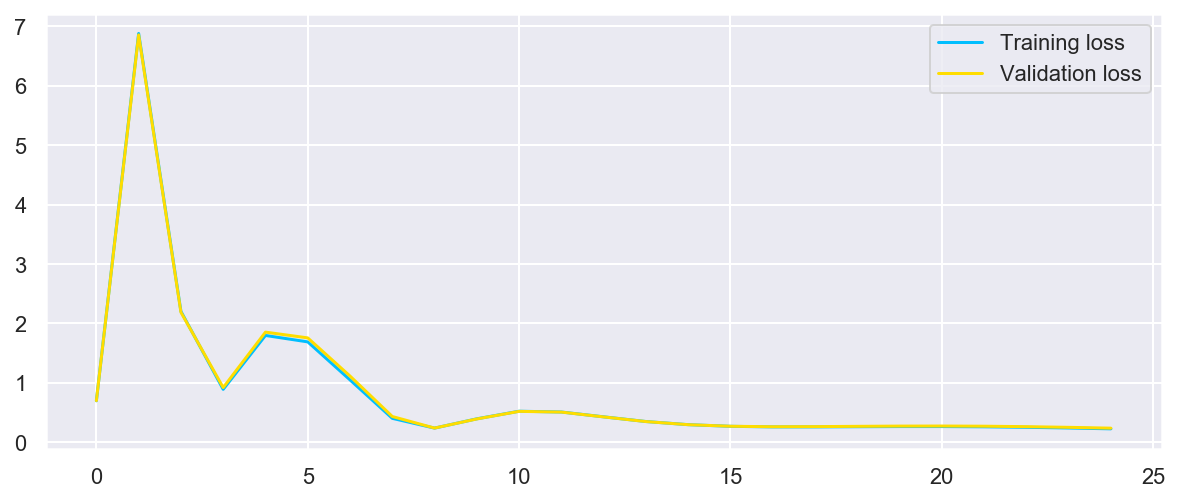

In [17]:
plt.figure(figsize = (10,4))
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [21]:
with torch.no_grad():
    output_train = model(train_x.type(torch.FloatTensor).cuda())
    output_val = model(val_x.type(torch.FloatTensor).cuda())
    output_test = model(test_x.type(torch.FloatTensor).cuda())

prediction_train = np.argmax(output_train.cpu(), axis=1)
prediction_val = np.argmax(output_val.cpu(), axis=1)
prediction_test = np.argmax(output_test.cpu(), axis=1)
print(accuracy_score(train_y, prediction_train))
print(accuracy_score(val_y, prediction_val))
print(accuracy_score(test_y, prediction_test))

0.9185690750764886
0.9183266932270916
0.9437751004016064
